## Cargamos las librerias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import time

## Cargamos el dataset de tweets y vemos su informacion

In [2]:
df_tweets = pd.read_csv("Tweets.csv", sep="|")
print(df_tweets.shape)
df_tweets.head()

(1583, 6)


,date,id,content,username,like_count,retweet_count
0,2023-02-11 22:55:17+00:00,1624542616707529984,@RipleyChile gente de ripley. Tengo un severo ...,Alexfuentesve,1.0,0.0
1,2023-02-11 22:43:20+00:00,1624539610083719936,@RipleyChile 12 horas esperando una respuesta ...,jcfunky,0.0,0.0
2,2023-02-11 22:03:43+00:00,1624529642391579904,@RipleyChile Gracias,claudiopavlik1,0.0,0.0
3,2023-02-11 21:46:58+00:00,1624525425341870080,@RipleyChile Por favor entreguen el producto q...,Marshmalun,0.0,0.0
4,2023-02-11 21:26:03+00:00,1624520161364410112,@Claumaysavage @RipleyChile sip,CespedesForever,0.0,0.0


In [3]:
df_tweets['username'].value_counts()[0:20]

RipleyChile        220
pamemartel          53
SERNAC              14
JorgeAl55035464     10
ayala_su             9
latoxica2910         8
Jovanoti77           8
Nacharizard          8
Maj0Majo             8
AgueroCLE            8
CespedesForever      7
VeroCanales          7
amolosgatitoos       7
cristobal_cbh        6
jonnymusci           6
Lagabriela1991       6
Alexfuentesve        6
alvarooock           6
kmilaespinoza        6
dsovino              6
Name: username, dtype: int64

In [4]:
df_tweets.isnull().sum()

date             0
id               0
content          0
username         0
like_count       0
retweet_count    0
dtype: int64

## Viendo que no hay valores nulos, establecemos si el tweet viene desde un usuario o desde la empresa

In [5]:
df_tweets.loc[df_tweets['username'] == 'RipleyChile', 'origen'] = 'Empresa'
df_tweets.loc[df_tweets['username'] == 'SERNAC', 'origen'] = 'SERNAC'
df_tweets["origen"].fillna("Usuario", inplace= True)
df_tweets.head()

,date,id,content,username,like_count,retweet_count,origen
0,2023-02-11 22:55:17+00:00,1624542616707529984,@RipleyChile gente de ripley. Tengo un severo ...,Alexfuentesve,1.0,0.0,Usuario
1,2023-02-11 22:43:20+00:00,1624539610083719936,@RipleyChile 12 horas esperando una respuesta ...,jcfunky,0.0,0.0,Usuario
2,2023-02-11 22:03:43+00:00,1624529642391579904,@RipleyChile Gracias,claudiopavlik1,0.0,0.0,Usuario
3,2023-02-11 21:46:58+00:00,1624525425341870080,@RipleyChile Por favor entreguen el producto q...,Marshmalun,0.0,0.0,Usuario
4,2023-02-11 21:26:03+00:00,1624520161364410112,@Claumaysavage @RipleyChile sip,CespedesForever,0.0,0.0,Usuario


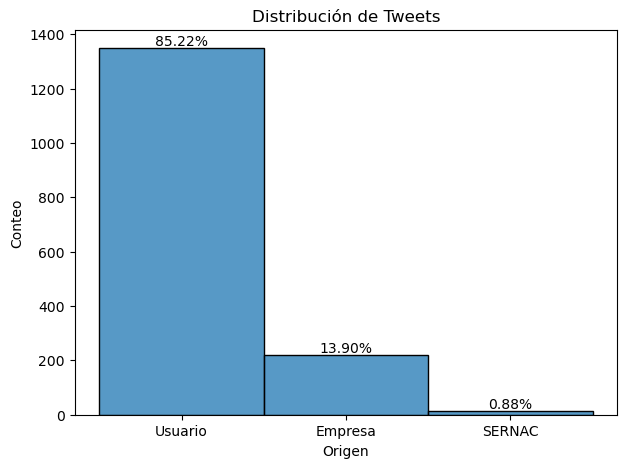

In [6]:
# Crear el gráfico de histograma
plt.figure(figsize=(7, 5))
ax = sns.histplot(data=df_tweets, x='origen')

# Obtener los valores de las barras
total = len(df_tweets)  # Total de datos
for patch in ax.patches:
    height = patch.get_height()  # Altura de cada barra (conteo)
    percentage = 100 * height / total  # Calcular el porcentaje
    ax.text(patch.get_x() + patch.get_width() / 2, height, f'{percentage:.2f}%', 
            ha='center', va='bottom')  # Etiqueta con el porcentaje

# Personalizar gráfico
plt.xlabel('Origen')
plt.ylabel('Conteo')
plt.title('Distribución de Tweets')

plt.show()

* Vemos que un 85% de los tweets son de parte de usuarios o clientes.

## Transformamos la fecha

In [7]:
df_tweets["fecha"] = df_tweets["date"].astype(str)
df_tweets["fecha"] = pd.to_datetime(df_tweets["fecha"].str[:10], format="%Y-%m-%d")
df_tweets.drop(columns='date', inplace= True)
df_tweets.head()

,id,content,username,like_count,retweet_count,origen,fecha
0,1624542616707529984,@RipleyChile gente de ripley. Tengo un severo ...,Alexfuentesve,1.0,0.0,Usuario,2023-02-11
1,1624539610083719936,@RipleyChile 12 horas esperando una respuesta ...,jcfunky,0.0,0.0,Usuario,2023-02-11
2,1624529642391579904,@RipleyChile Gracias,claudiopavlik1,0.0,0.0,Usuario,2023-02-11
3,1624525425341870080,@RipleyChile Por favor entreguen el producto q...,Marshmalun,0.0,0.0,Usuario,2023-02-11
4,1624520161364410112,@Claumaysavage @RipleyChile sip,CespedesForever,0.0,0.0,Usuario,2023-02-11


## Cargamos el modelo pre-entrenado y el tokenizador

### El modelo a utlizar será una versión multi lenguaje de bert, obtenido desde hugging face:
* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [8]:
nombre_modelo = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(nombre_modelo)
modelo = AutoModelForSequenceClassification.from_pretrained(nombre_modelo)

## Ahora armaremos algunas funciones que nos permitan limpiar el tweet antes de obtener el sentimiento

In [9]:
def mencion_sernac(words):
    sernac = "No"
    for word in words:
        if word.lower().find("sernac") != -1:
            sernac = "Si"
    return sernac

In [10]:
def quitar_menciones(words):
    palabras = []
    for word in words:
        if ((word.startswith('@')) & (len(word) > 1)):
            palabra = ''
        elif word.startswith('http'):
            palabra = ''
        else:
            palabra = word
        palabras.append(palabra)
        texto = ' '.join(palabras)
    return texto

In [11]:
def obtener_sentimiento(df):
    inputs = tokenizer(df, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = modelo(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(probs).item()
    
    # Mapeo de los resultados a sentimiento (0: muy negativo, 4: muy positivo)
    sentiment_map = {0: 'Muy negativo', 1: 'Negativo', 2: 'Neutral', 3: 'Positivo', 4: 'Muy positivo'}
    return sentiment_map[sentiment]

In [12]:
# Procesamos el texto y luego obtenemos las menciones al SERNAC y el sentimiento del tweet
start_time = time.time()

df_tweets["texto_procesado"] = df_tweets["content"].astype(str).str.lower()
df_tweets["texto_procesado"] = df_tweets["texto_procesado"].str.split(' ')

df_tweets["Sernac"] = df_tweets["texto_procesado"].apply(mencion_sernac)
df_tweets["texto_procesado"] = df_tweets['texto_procesado'].apply(quitar_menciones)
df_tweets['Sentimiento'] = df_tweets['texto_procesado'].apply(obtener_sentimiento)

print("--- Procesamiento del texto: %s seconds ---" % (time.time() - start_time))

--- Procesamiento del texto: 204.72779297828674 seconds ---


In [13]:
df_tweets.head()

,id,content,username,like_count,retweet_count,origen,fecha,texto_procesado,Sernac,Sentimiento
0,1624542616707529984,@RipleyChile gente de ripley. Tengo un severo ...,Alexfuentesve,1.0,0.0,Usuario,2023-02-11,gente de ripley. tengo un severo reclamo con ...,Si,Muy negativo
1,1624539610083719936,@RipleyChile 12 horas esperando una respuesta ...,jcfunky,0.0,0.0,Usuario,2023-02-11,12 horas esperando una respuesta del status d...,Si,Muy negativo
2,1624529642391579904,@RipleyChile Gracias,claudiopavlik1,0.0,0.0,Usuario,2023-02-11,gracias,No,Muy positivo
3,1624525425341870080,@RipleyChile Por favor entreguen el producto q...,Marshmalun,0.0,0.0,Usuario,2023-02-11,por favor entreguen el producto que compre di...,No,Muy negativo
4,1624520161364410112,@Claumaysavage @RipleyChile sip,CespedesForever,0.0,0.0,Usuario,2023-02-11,sip,No,Neutral


## Ahora haremos algunos análisis respecto al sentimiento y las meciones a Sernac de los usuarios (Se excluyen Empresa y SERNAC)

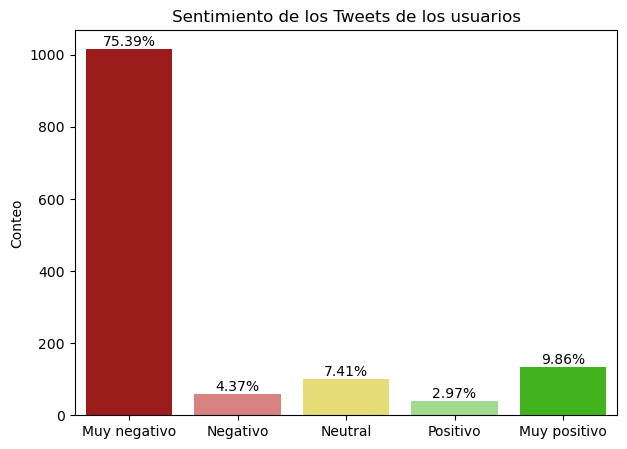

In [15]:
# Establecemos el orden de las columnas
order = ['Muy negativo', 'Negativo', 'Neutral', 'Positivo', 'Muy positivo']

# Definir colores específicos para cada categoría
colors = ['#b00505', '#e67373', '#f7eb63', '#9be882', '#36cc04']

# Crear el gráfico de histograma
plt.figure(figsize=(7, 5))
ax = sns.countplot(data=df_tweets[df_tweets['origen'] == 'Usuario'], x='Sentimiento', order=order, palette=colors)

# Obtener los valores de las barras
total = len(df_tweets[df_tweets['origen'] == 'Usuario'])  # Total de datos
for patch in ax.patches:
    height = patch.get_height()  # Altura de cada barra (conteo)
    percentage = 100 * height / total  # Calcular el porcentaje
    ax.text(patch.get_x() + patch.get_width() / 2, height, f'{percentage:.2f}%', 
            ha='center', va='bottom')  # Etiqueta con el porcentaje

# Personalizar gráfico
plt.ylabel('Conteo')
plt.xlabel('')
plt.title('Sentimiento de los Tweets de los usuarios')

plt.show()

### Vemos que alrededor del 80% de los tweets corresponden a comentarios negativos sobre la empresa

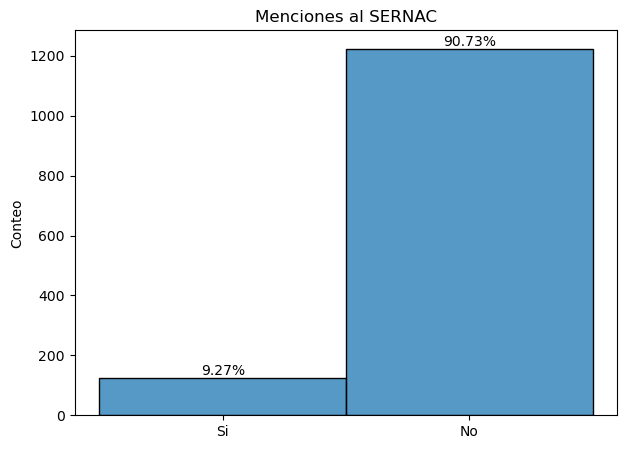

In [16]:
# Crear el gráfico de histograma
plt.figure(figsize=(7, 5))
ax = sns.histplot(data=df_tweets[df_tweets['origen'] == 'Usuario'], x='Sernac')

# Obtener los valores de las barras
total = len(df_tweets[df_tweets['origen'] == 'Usuario'])  # Total de datos
for patch in ax.patches:
    height = patch.get_height()  # Altura de cada barra (conteo)
    percentage = 100 * height / total  # Calcular el porcentaje
    ax.text(patch.get_x() + patch.get_width() / 2, height, f'{percentage:.2f}%', 
            ha='center', va='bottom')  # Etiqueta con el porcentaje

# Personalizar gráfico
plt.xlabel('')
plt.ylabel('Conteo')
plt.title('Menciones al SERNAC')

plt.show()

### Por otro lado, los usuarios mencionan al sernac un 9% de las veces

# Guardamos el archivo con los resultados

In [75]:
df_tweets.to_csv('Tweets_con_sentimiento.csv', index=False)